In [1]:
from env import ShogiEnv
import gymnasium as gym
import numpy as np

gym.register(id="Shogi-v0", entry_point="env:ShogiEnv", kwargs={})
env: ShogiEnv = gym.make("Shogi-v0")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# This is our final mask layer
class MaskLayer(torch.nn.Module):

    def __init__(self):
        super(MaskLayer, self).__init__()
    
    # mask is made of 0s/1s so it will just set to 0 any invalid move
    def forward(self, x, mask):
        return torch.mul(x, mask)

In [3]:
class DQN(nn.Module):

    def __init__(self):
        
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(14, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
 
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128*9*9, 128*81)
        
        self.fc2 = nn.Linear(128*81, 81*81)
        
        self.mask = MaskLayer()

    def forward(self, x, mask=None, debug=False):
        
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        
        x = nn.functional.relu(self.bn3(self.conv3(x)))

        x = nn.functional.relu(self.bn4(self.conv4(x)))
        
        x = nn.Flatten()(x)
        
        x = nn.functional.relu(self.fc1(x))
        
        x = self.fc2(x)
        
        if mask is not None:
            x = self.mask(x, mask)
            
        return x

In [11]:
import random

class ShogiAgent:

    def __init__(self, input_model_path=None):
        self.epsilon = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.1

        self.gamma = 0.5
        self.learning_rate = 1e-03
        self.MEMORY_SIZE = 512
        self.MAX_PRIORITY = 1e+06
        self.memory = []
        self.batch_size = 16

        self.q_network = DQN()
        self.target_network = self.q_network

        if input_model_path is not None:
            self.target_network.load_state_dict(torch.load(input_model_path))
            self.q_network.load_state_dict(torch.load(input_model_path))

        self.loss_function = nn.MSELoss()

        self.optimizer = torch.optim.Adam(self.target_network.parameters(), lr=self.learning_rate)

    def get_move_index(self, move):
        index = 81 * (move.from_square) + (move.to_square)
        return index
        
    def remember(self, priority, state, action, reward, next_state, done, valid_moves, next_valid_moves):

        # if memory is full, we delete the least priority element
        if len(self.memory) >= self.MEMORY_SIZE:
            
            min_value = self.MAX_PRIORITY
            min_index = 0
            
            for i,n in enumerate(self.memory):
                
                # priority is stored in the first position of the tuple
                if n[0] < min_value:
                    min_value = n[0]
                    min_index = i
            
            del self.memory[min_index]

        self.memory.append((priority, state, action, reward, next_state, done, valid_moves, next_valid_moves))

    # Take a board as input and return a valid move defined as tuple (start square, end square)
    def select_action(self, env):
        
        # get valid moves
        valid_moves, valid_move_dict = env.mask_and_valid_moves()
        valid_moves_tensor = torch.from_numpy(valid_moves).float().unsqueeze(0)
        current_state = env.get_state()[0]
        current_state_tensor = torch.from_numpy(current_state).float().unsqueeze(0)
        valid_moves_tensor = valid_moves_tensor.view(current_state_tensor.size(0), -1)
        
        # with probability epsilon = Explore
        if random.uniform(0, 1) <= self.epsilon:
            
            r = random.uniform(0, 1)
            
            # inside exploration with probability 10% choose best move from policy network
            if r <= 0.1:
                policy_values = self.target_network(current_state_tensor, valid_moves_tensor)
                chosen_move_index = int(policy_values.max(1)[1].view(1,1))
                if chosen_move_index in valid_move_dict:
                    chosen_move = valid_move_dict[chosen_move_index]
                else:
                    chosen_move = env.sample_action()
            
            # with probability 90% choose a random move
            else:
                chosen_move = random.choice(list(valid_move_dict.values()))
        
        # with probability 1 - epsilon = Exploit
        else:
            
            # during inference we don't need to compute gradients
            with torch.no_grad():
                
                # predict rewards for each valid move in the current state. valid_moves_tensor is the mask!
                policy_values = self.target_network(current_state_tensor, valid_moves_tensor)
                
                # take the move index with the highest predicted reward
                chosen_move_index = int(policy_values.max(1)[1].view(1,1))
                
                # if move is valid:
                if chosen_move_index in valid_move_dict:
                    chosen_move = valid_move_dict[chosen_move_index]
                    
                # if move is NOT valid, choose random move
                # this can happen if all valid moves have predicted values 0 or negative
                else:
                    chosen_move = env.sample_action()

        return self.get_move_index(chosen_move), chosen_move, current_state, valid_moves

    
    # Decay epsilon (exploration rate)
    def adaptiveEGreedy(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        
    # Save trained model
    def save_model(self, path):
        torch.save(self.target_network.state_dict(), path)

    def learn_experience_replay(self, debug=False):
            
        # if memory does not have enough sample to fill a batch, return
        if len(self.memory) < self.batch_size:
            return
    
        # get priorities from the first element in the memory samples tuple
        priorities = [x[0] for x in self.memory]
        
        # the higher the priority, the more probable the sample will be included in the batch training
        priorities_total = np.sum(priorities)
        weights = priorities / priorities_total
    
        # extract samples for the batch training
        minibatch_indexes = np.random.choice(range(len(self.memory)), size=self.batch_size, replace=False, p=weights)
        minibatch = [self.memory[x] for x in minibatch_indexes]
    
        # unpack the tuples in the batch into different lists, to be converted into tensors
        state_list = []
        state_valid_moves = []
        action_list = []
        reward_list = []
        next_state_list = []
        next_state_valid_moves = []
        done_list = []
    
        for priority, bit_state, action, reward, next_bit_state, done, state_valid_move, next_state_valid_move in minibatch:
        
            # bit state is the 16 bitboards of the state before the move
            state_list.append(bit_state)
            
            # state_valid_moves is a tensor containing the indexes of valid moves (out of 6561)
            state_valid_moves.append(state_valid_move.unsqueeze(0))
            
            # action is the index of the chosen move (out of 6561)
            action_list.append([action])
            
            # reward is the reward obtained by making the chosen move
            reward_list.append(reward)
            
            # done indicates if the game ended after making the chosen move
            done_list.append(done)
    
            if not done:
                
                # next_bit_state is the 16 bitboards of the state after the move
                next_state_list.append(next_bit_state)
                
                # next_state_valid_moves is a tensor containing the indexes of valid moves (out of 6561)
                next_state_valid_moves.append(next_state_valid_move.unsqueeze(0))
    
        # state_valid_moves and next_state_valid_moves are already tensors, we just need to concat them
        state_valid_move_tensor = torch.cat(state_valid_moves, 0)
        next_state_valid_move_tensor = torch.cat(next_state_valid_moves, 0)
    
        # convert all lists to tensors
        state_tensor = torch.from_numpy(np.array(state_list)).float()
        action_list_tensor = torch.from_numpy(np.array(action_list, dtype=np.int64))
        reward_list_tensor = torch.from_numpy(np.array(reward_list)).float()
        next_state_tensor = torch.from_numpy(np.array(next_state_list)).float()
        
        # create a tensor with 
        bool_array = np.array([not x for x in done_list])
        not_done_mask = torch.tensor(bool_array, dtype=torch.bool)
        
        # compute the expected rewards for each valid move
        policy_action_values = self.q_network(state_tensor, state_valid_move_tensor)
        
        # get only the expected reward for the chosen move (to calculate loss against the actual reward)
        policy_action_values = policy_action_values.gather(1, action_list_tensor)
        
        # target values are what we want the network to predict (our actual values in the loss function)
        # target values = reward + max_reward_in_next_state * gamma
        # gamma is the discount factor and tells the agent whether to prefer long term rewards or immediate rewards. 0 = greedy, 1 = long term 
        max_reward_in_next_state = torch.zeros(self.batch_size, dtype=torch.double)
        
        with torch.no_grad():
            
            # if the state is final (done = True, not_done_mask = False) the max_reward_in_next_state stays 0
            max_reward_in_next_state[not_done_mask] = self.target_network(next_state_tensor, next_state_valid_move_tensor).max(1)[0]
        
        target_action_values = (max_reward_in_next_state * self.gamma) + reward_list_tensor
        target_action_values = target_action_values.unsqueeze(1)
        
        # loss is computed between expected values (predicted) and target values (actual)
        loss = self.loss_function(policy_action_values, target_action_values)
    
        # Update priorities of samples in memory based on size of error (higher error = higher priority)
        for i in range(self.batch_size):
            
            predicted_value = policy_action_values[i]
            target_value = target_action_values[i]
            
            # priority = mean squared error
            priority = F.mse_loss(predicted_value, target_value, reduction='mean').detach().numpy()
            
            # change priority of sample in memory
            sample = list(self.memory[minibatch_indexes[i]])
            sample[0] = priority
            self.memory[minibatch_indexes[i]] = tuple(sample)
    
        # clear gradients of all parameters from the previous training step
        self.optimizer.zero_grad()
        
        # calculate the new gradients of the loss with respect to all the model parameters by traversing the network backwards
        loss.backward()
        
        # adjust model parameters (weights, biases) according to computed gradients and learning rate
        self.optimizer.step()

        self.target_network = self.q_network
        
        if debug:
            print("state_tensor shape", state_tensor.shape)
            print("\naction_list_tensor shape", action_list_tensor.shape)
            print("\naction_list_tensor (chosen move out of 4096)", action_list_tensor)
            print("\npolicy_action_values (expected reward of chosen move)", policy_action_values)
            print("\nnot_done_mask", not_done_mask)
            print("\ntarget_action_values", target_action_values)
            print("\nreward_list_tensor", reward_list_tensor)
            print("\nloss:", loss)
    
        # return loss so that we can plot loss by training step
        return float(loss)

## Train the Agent

In [5]:
agent = ShogiAgent()

env.reset()

for i in range(16):
    valid_moves, _ = env.mask_and_valid_moves()

    state = env.get_state()

    action = env.sample_action()
    action_index = agent.get_move_index(action)

    next_state, reward, terminated, truncated, _ = env.step(action)

    next_valid_moves, _ = env.mask_and_valid_moves()

    valid_moves = torch.from_numpy(valid_moves.flatten())
    next_valid_moves = torch.from_numpy(next_valid_moves.flatten())
    agent.remember(1, state[0], action_index, reward, next_state[0], terminated, valid_moves, next_valid_moves)

len(agent.memory)

c:\Users\airel\OneDrive\Documents\Fontys\S7\Individual\venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:193: UserWarning: WARN: The result returned by `env.reset()` should be `(obs, info)` by default, , where `obs` is a observation and `info` is a dictionary containing additional information.
  logger.warn(
c:\Users\airel\OneDrive\Documents\Fontys\S7\Individual\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.mask_and_valid_moves to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.mask_and_valid_moves` for environment variables or `env.get_wrapper_attr('mask_and_valid_moves')` that will search the reminding wrappers.
  logger.warn(
c:\Users\airel\OneDrive\Documents\Fontys\S7\Individual\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.get_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.u

16

In [6]:
agent.learn_experience_replay(debug=True)

state_valid_move_tensor shape torch.Size([16, 6561])
state_tensor shape torch.Size([16, 14, 9, 9])

action_list_tensor shape torch.Size([16, 1])

action_list_tensor (chosen move out of 4096) tensor([[5737],
        [6387],
        [ 327],
        [6306],
        [5584],
        [1057],
        [ 256],
        [6224],
        [ 819],
        [ 739],
        [5659],
        [ 418],
        [1485],
        [4993],
        [1813],
        [6551]])

policy_action_values (expected reward of chosen move) tensor([[ 0.1347],
        [-0.0851],
        [ 0.0683],
        [ 0.0077],
        [ 0.0012],
        [-0.2398],
        [ 0.0602],
        [-0.1392],
        [-0.1026],
        [ 0.1668],
        [-0.1589],
        [-0.1140],
        [ 0.3311],
        [ 0.2506],
        [-0.0618],
        [ 0.0819]], dtype=torch.float64, grad_fn=<GatherBackward0>)

not_done_mask tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

target_action_v

0.05748938229632814

state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 6561])
state_valid_move_tensor shape torch.Size([16, 

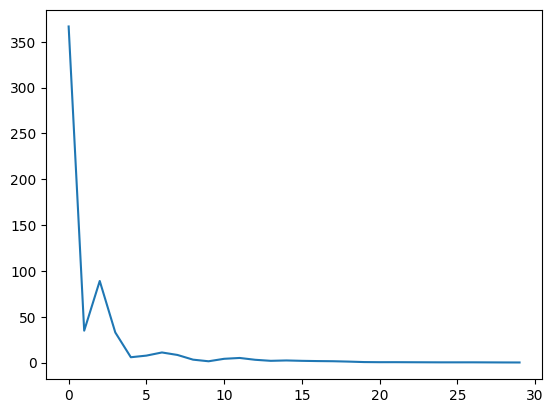

In [7]:
import matplotlib.pyplot as plt

loss = []
for i in range(30):
    loss.append(agent.learn_experience_replay(debug=False))

plt.plot(loss)
plt.show()

In [12]:
import time
import pandas as pd

def Q_learning(agent, games_to_play):

    loss = []
    final_score = []
    games = 0
    steps = 0

    # we play n games
    while games < games_to_play:
        
        print("Game", games + 1, "of", games_to_play)
        games += 1
        done = False
        game_moves = 0

        env.reset()

        # until game is not finished
        while not done:

            game_moves += 1
            steps += 1

            # choose action, here the agent choose whether to explore or exploit
            action_index, move, current_bit_state, valid_moves_tensor = agent.select_action(env)
            valid_moves = torch.from_numpy(valid_moves_tensor.flatten())
            
            if done:
                agent.remember(agent.MAX_PRIORITY, current_bit_state, action_index, reward, None, done, valid_moves, None)
                board_score_after = reward
                
            # game not finished
            else:

                next_bit_state, reward, terminated, truncated, _ = env.step(move)

                # is game finished?
                if terminated or truncated:
                    done = True
                    board_score_after = reward

                next_valid_moves, _ = env.mask_and_valid_moves()

                next_valid_moves_tensor = torch.from_numpy(next_valid_moves.flatten())
                                
                # store sample in memory
                agent.remember(agent.MAX_PRIORITY, current_bit_state, action_index, reward, next_bit_state[0], done, valid_moves, next_valid_moves_tensor)
                                

            # train model and store loss
            loss.append(agent.learn_experience_replay(debug=False))

            # adjust epsilon (exploration rate)
            agent.adaptiveEGreedy()

        # save final game score
        final_score.append(board_score_after)

    # plot training results
    score_df = pd.DataFrame(final_score, columns=["score"])
    score_df['ma'] = score_df["score"].rolling(window = games // 5).mean()
    loss_df = pd.DataFrame(loss, columns=["loss"])
    loss_df['ma'] = loss_df["loss"].rolling(window=steps // 5).mean()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot the score chart in the first subplot
    ax1.plot(score_df.index, score_df["score"], linewidth=0.2)
    ax1.plot(score_df.index, score_df["ma"])
    ax1.set_title('Final score by game')

    # Plot the loss chart in the second subplot
    ax2.plot(loss_df.index, loss_df["loss"], linewidth=0.1)
    ax2.plot(loss_df.index, loss_df["ma"])
    ax2.set_title('Loss by training step')

    # Show the plot
    plt.show()

Game 1 of 10


c:\Users\airel\OneDrive\Documents\Fontys\S7\Individual\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.sample_action to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sample_action` for environment variables or `env.get_wrapper_attr('sample_action')` that will search the reminding wrappers.
  logger.warn(


Game 2 of 10
Game 3 of 10
Game 4 of 10
Game 5 of 10
Game 6 of 10
Game 7 of 10
Game 8 of 10
Game 9 of 10
Game 10 of 10


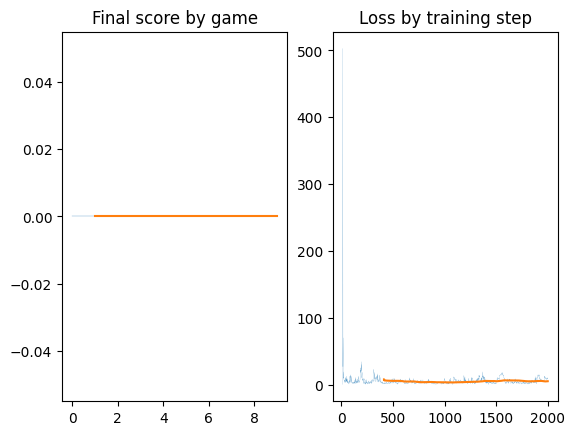

In [15]:
agent = ShogiAgent()
env.reset()

Q_learning(agent, games_to_play=10)

Game 1 of 20


c:\Users\airel\OneDrive\Documents\Fontys\S7\Individual\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.mask_and_valid_moves to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.mask_and_valid_moves` for environment variables or `env.get_wrapper_attr('mask_and_valid_moves')` that will search the reminding wrappers.
  logger.warn(
c:\Users\airel\OneDrive\Documents\Fontys\S7\Individual\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.get_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_state` for environment variables or `env.get_wrapper_attr('get_state')` that will search the reminding wrappers.
  logger.warn(


Game 2 of 20
Game 3 of 20
Game 4 of 20
Game 5 of 20
Game 6 of 20


c:\Users\airel\OneDrive\Documents\Fontys\S7\Individual\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.sample_action to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sample_action` for environment variables or `env.get_wrapper_attr('sample_action')` that will search the reminding wrappers.
  logger.warn(


Game 7 of 20
Game 8 of 20
Game 9 of 20
Game 10 of 20
Game 11 of 20
Game 12 of 20
Game 13 of 20
Game 14 of 20
Game 15 of 20
Game 16 of 20
Game 17 of 20
Game 18 of 20
Game 19 of 20
Game 20 of 20


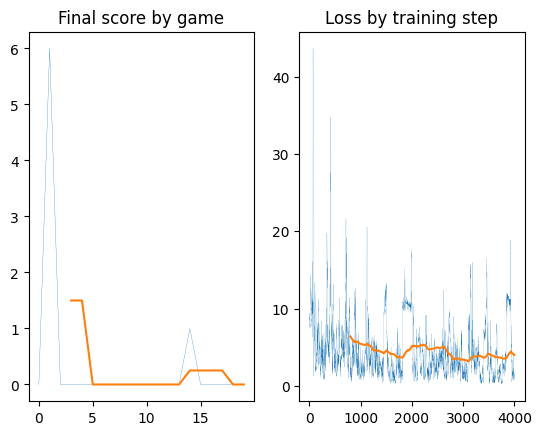

In [16]:
Q_learning(agent, games_to_play=20)

In [20]:
agent.save_model("shogimodel/second_model.pth")